In [1]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import base, metrics, model_selection, preprocessing, tree, utils
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
import shap
import xgboost as xgb
import pandas_profiling
import itertools
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

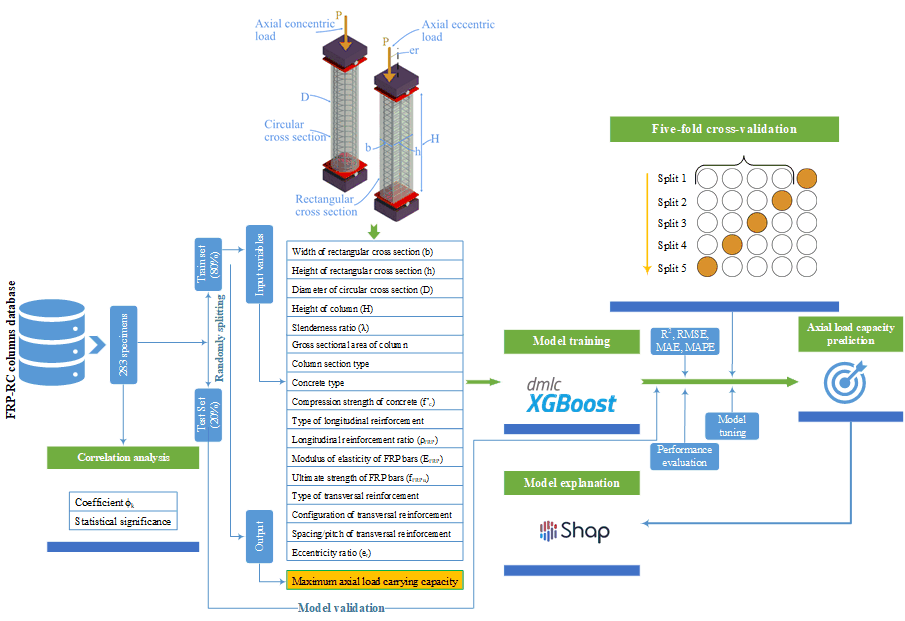

In [2]:
Image(filename='XGBoost prediction.png' )

# 1.0 Import the Data


In [3]:
# Read in the Data
Donnees = pd.read_excel("FRP-RC_Columns_Database.xlsx", usecols="A:AA", header=0)
Donnees.head()

,No.,Spec.,b,h,D,H,LamdaC,Ag,Circular,TypeCon,...,TypeH,Bars.1,Config,SpacPitch,EfrpH,ffuH,efuH,e,EoverD,Pexp
0,1,A-12,610,610,-,3000,17,372100,No,NWC,...,GFRP,No. 4,Ties,305,-,-,-,0.0,0,15235.000
1,2,B-12,610,610,-,3000,17,372100,No,NWC,...,GFRP,No. 4,Ties,305,-,-,-,0.0,0,12949.000
2,3,A-3,610,610,-,3000,17,372100,No,NWC,...,GFRP,No. 4,Ties,76,-,-,-,0.0,0,11926.000
3,4,B-3,610,610,-,3000,17,372100,No,NWC,...,GFRP,No. 4,Ties,76,-,-,-,0.0,0,10751.000
4,5,C-G-1-120,350,350,-,1400,14,122500,No,NWC,...,GFRP,No.13 ties,Ties,120,44,640,1.45,0.0,0,3928.575


# 2.0 Convert into Numerical Values


In [4]:
Donnees['LamdaC'] = Donnees['LamdaC'].astype(float)
Donnees['SpacPitch'] = Donnees['SpacPitch'].astype(float)
Donnees['EoverD'] = Donnees['EoverD'].astype(float)
Donnees['ffuL'] = Donnees['ffuL'].astype(float)
Donnees['Ag'] = Donnees['Ag'].astype(float)
Donnees['fcp'] = Donnees['fcp'].astype(float)
Donnees['RhoEf'] = Donnees['RhoEf'].astype(float)
Donnees['Pexp'] = Donnees['Pexp'].astype(float)
Donnees['EfrpL'] = Donnees['EfrpL'].astype(float)

In [5]:
# All the Data
Data= Donnees[[ 'LamdaC','Circular', 'Ag', 'TypeCon', 'fcp', 'TypeL', 'RhoEf', 'EfrpL', 'ffuL', 'TypeH', 'Config', 'SpacPitch','EoverD','Pexp']]

# Data without confinement
DataNoConfin= Donnees[[ 'LamdaC','Circular', 'Ag', 'TypeCon', 'fcp', 'TypeL', 'RhoEf', 'EfrpL', 'ffuL', 'EoverD','Pexp']]

# Concentric RC-Columns only
DataConcentric = Data[(Data["EoverD"]==0)]

# Eccentric RC-Columns only
DataExcentric =  Data[(Data["EoverD"] > 0)]

# 3.0 Exploratory Data Analysis 

In [6]:
Data.describe()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,SpacPitch,EoverD,Pexp
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,21.621908,75532.261484,44.680000,2.083463,70.640106,1248.183746,100.063604,20.420495,2019.014558
std,7.613106,50424.293536,14.452926,0.872961,35.621739,390.870253,51.252983,25.289877,1867.339592
min,10.000000,14400.000000,25.600000,0.550000,39.000000,574.000000,30.000000,0.000000,90.000000
25%,17.000000,41600.000000,35.000000,1.400000,50.000000,930.000000,80.000000,0.000000,789.900000
50%,20.000000,73062.000000,42.300000,2.180000,55.400000,1289.000000,80.000000,12.000000,1483.000000
75%,21.000000,73062.000000,52.000000,2.220000,62.700000,1449.000000,120.000000,33.000000,2962.000000
max,62.000000,372100.000000,90.000000,4.800000,151.000000,2000.000000,305.000000,100.000000,15235.000000


In [7]:
DataNoConfin.describe()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,EoverD,Pexp
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,21.621908,75532.261484,44.680000,2.083463,70.640106,1248.183746,20.420495,2019.014558
std,7.613106,50424.293536,14.452926,0.872961,35.621739,390.870253,25.289877,1867.339592
min,10.000000,14400.000000,25.600000,0.550000,39.000000,574.000000,0.000000,90.000000
25%,17.000000,41600.000000,35.000000,1.400000,50.000000,930.000000,0.000000,789.900000
50%,20.000000,73062.000000,42.300000,2.180000,55.400000,1289.000000,12.000000,1483.000000
75%,21.000000,73062.000000,52.000000,2.220000,62.700000,1449.000000,33.000000,2962.000000
max,62.000000,372100.000000,90.000000,4.800000,151.000000,2000.000000,100.000000,15235.000000


In [8]:
DataConcentric.describe()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,SpacPitch,EoverD,Pexp
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.0,117.000000
mean,20.000000,74490.769231,40.745641,1.989060,71.265385,1197.564103,92.649573,0.0,2916.384359
std,6.293127,61676.274197,12.398463,0.769971,35.887616,423.381816,48.282630,0.0,2262.812456
min,10.000000,22500.000000,25.600000,0.550000,39.000000,574.000000,30.000000,0.0,792.000000
25%,16.000000,41548.000000,33.150000,1.630000,48.200000,913.000000,75.000000,0.0,1223.000000
50%,20.000000,73062.000000,39.000000,2.170000,55.400000,1184.000000,80.000000,0.0,2871.000000
75%,21.000000,73062.000000,44.700000,2.200000,62.600000,1449.000000,120.000000,0.0,3490.000000
max,42.000000,372100.000000,90.000000,4.660000,151.000000,2000.000000,305.000000,0.0,15235.000000


In [9]:
DataExcentric.describe()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,SpacPitch,EoverD,Pexp
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,22.765060,76266.325301,47.453012,2.150000,70.199398,1283.861446,105.289157,34.813253,1386.531024
std,8.248356,40864.877151,15.173118,0.935341,35.535327,363.313771,52.765469,24.269349,1177.418860
min,13.000000,14400.000000,26.800000,0.730000,39.000000,654.000000,30.000000,8.000000,90.000000
25%,17.000000,41600.000000,35.000000,1.340000,51.300000,938.250000,80.000000,16.000000,481.500000
50%,20.000000,73062.000000,43.500000,2.180000,54.900000,1289.000000,80.000000,26.000000,961.500000
75%,22.750000,73062.000000,52.000000,2.300000,63.700000,1558.000000,150.000000,50.000000,1967.000000
max,62.000000,164025.000000,90.000000,4.800000,151.000000,2000.000000,300.000000,100.000000,5294.000000


## 3.1 Correlation Phik (φk)

In [10]:
interval_cols = ['LamdaC', 'Ag', 'fcp', 'RhoEf', 'EfrpL', 'ffuL', 'SpacPitch', 'EsurD', 'Pexp']
bins = {'LamdaC':30, 'Ag':30,'fcp':30, 'RhoEf':30, 'EfrpL':30, 'ffuL':30, 'SpacPitch':30, 'EsurD':30, 'Pexp':30}
phik_overview = Data.phik_matrix(interval_cols=interval_cols, bins=bins)
phik_overview

,LamdaC,Circular,Ag,TypeCon,fcp,TypeL,RhoEf,EfrpL,ffuL,TypeH,Config,SpacPitch,EoverD,Pexp
LamdaC,1.000000,0.864615,0.936649,0.721265,0.911762,0.703771,0.890480,0.883426,0.910166,0.814907,0.757347,0.834158,0.772610,0.530003
Circular,0.864615,1.000000,0.797128,0.153649,0.876273,0.130230,0.855284,0.908182,0.903281,0.631972,0.727902,0.920992,0.811196,0.469221
Ag,0.936649,0.797128,1.000000,0.750110,0.896975,0.796142,0.930315,0.877836,0.954866,0.811730,0.850543,0.887190,0.853947,0.787036
TypeCon,0.721265,0.153649,0.750110,1.000000,0.904119,0.312957,0.561169,0.712630,0.794808,0.126156,0.520740,0.642777,0.513045,0.293096
fcp,0.911762,0.876273,0.896975,0.904119,1.000000,0.801059,0.897038,0.881966,0.933425,0.965607,0.708621,0.895594,0.857569,0.768322
TypeL,0.703771,0.130230,0.796142,0.312957,0.801059,1.000000,0.902208,0.912646,0.909944,0.789929,0.411599,0.677236,0.654275,0.195730
RhoEf,0.890480,0.855284,0.930315,0.561169,0.897038,0.902208,1.000000,0.899321,0.923724,0.914951,0.819726,0.865709,0.762631,0.474668
EfrpL,0.883426,0.908182,0.877836,0.712630,0.881966,0.912646,0.899321,1.000000,0.948655,0.945856,0.787806,0.790785,0.723123,0.635845
ffuL,0.910166,0.903281,0.954866,0.794808,0.933425,0.909944,0.923724,0.948655,1.000000,0.890004,0.731290,0.853004,0.735133,0.778147
TypeH,0.814907,0.631972,0.811730,0.126156,0.965607,0.789929,0.914951,0.945856,0.890004,1.000000,0.328334,0.777526,0.729265,0.201288


In [11]:
Sxindex=[r'$\lambda$', r'$section_{type}$', r'$A_g$', r'$concrete_{type}$', r'$f^\prime_c$', r'$l_{type}$', r'$\rho_{FRP}$', r'$E_{FRP}$',
       r'$f_{FRPu}$', r'$t_{type}$', r'$t_{conf}$', r'$t_{spacing}$', r'$e_{r}$', r'$P_{max}$']
Syindex=[r'$\lambda$',r'$section_{type}$', r'$A_g$',  r'$concrete_{type}$', r'$f^\prime_c$', r'$l_{type}$', r'$\rho_{FRP}$', r'$E_{FRP}$',
       r'$f_{FRPu}$', r'$t_{type}$', r'$t_{conf}$', r'$t_{spacing}$', r'$e_{r}$', r'$P_{max}$']

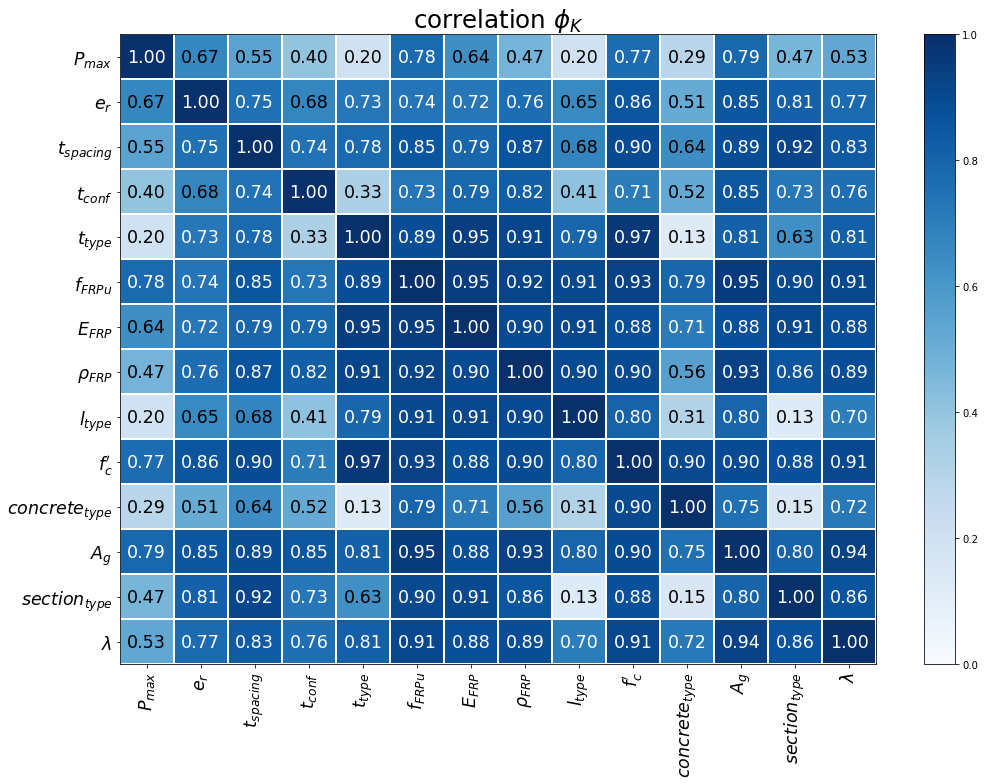

In [12]:
plot_correlation_matrix(phik_overview.values, x_labels=Sxindex, y_labels=Syindex, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.75,
                        figsize=(15,11))
plt.tight_layout()

In [13]:
significance_overview = Data.significance_matrix(interval_cols=interval_cols, bins = bins)
significance_overview

,LamdaC,Circular,Ag,TypeCon,fcp,TypeL,RhoEf,EfrpL,ffuL,TypeH,Config,SpacPitch,EoverD,Pexp
LamdaC,26.991448,14.113567,20.831762,7.797917,18.709393,8.415364,15.887553,18.127028,17.904086,11.234759,13.153708,14.693717,9.648780,7.277120
Circular,14.113567,19.196179,14.317440,4.839941,12.272478,3.274734,12.606039,12.610551,12.429415,7.670240,18.163313,12.833177,10.237544,5.025446
Ag,20.831762,14.317440,26.589881,7.620026,19.425488,9.145993,17.289413,17.890187,17.716805,12.824120,13.376294,18.480276,12.797906,9.613320
TypeCon,7.797917,4.839941,7.620026,16.578754,11.619519,1.869425,3.687753,6.865662,8.171323,2.949018,5.068914,5.944835,2.650537,2.543522
fcp,18.709393,12.272478,19.425488,11.619519,28.953439,10.284600,15.438671,18.726961,19.556659,12.902231,11.373263,14.194397,10.497496,9.550564
TypeL,8.415364,3.274734,9.145993,1.869425,10.284600,19.316330,9.754423,12.874344,13.073711,15.731689,2.939388,6.662396,4.166781,1.333451
RhoEf,15.887553,12.606039,17.289413,3.687753,15.438671,9.754423,26.418863,16.120811,16.983414,12.663438,11.496639,13.562109,7.606617,5.318906
EfrpL,18.127028,12.610551,17.890187,6.865662,18.726961,12.874344,16.120811,29.156687,21.380752,13.984975,11.137210,12.796866,7.544832,6.528832
ffuL,17.904086,12.429415,17.716805,8.171323,19.556659,13.073711,16.983414,21.380752,26.773005,12.631808,10.512165,13.032819,7.711717,7.889137
TypeH,11.234759,7.670240,12.824120,2.949018,12.902231,15.731689,12.663438,13.984975,12.631808,20.386133,7.215635,8.696899,6.619819,1.916840


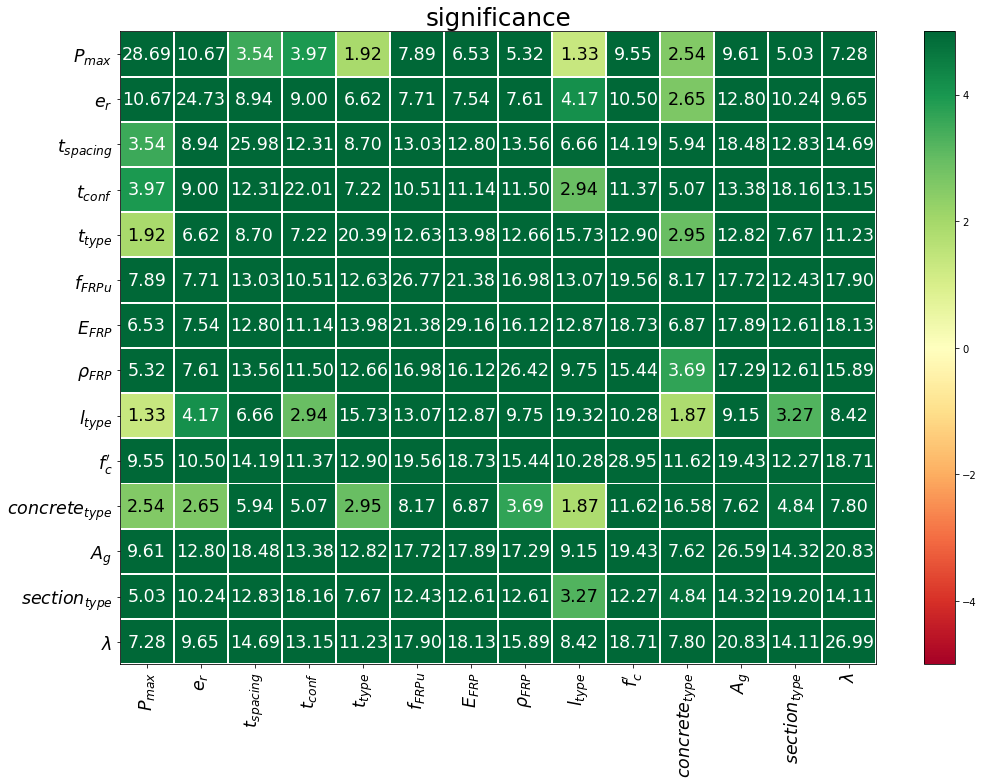

In [14]:
plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=Sxindex, 
                        y_labels=Syindex, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.75, figsize=(15,11))


## 3.2 Pairwise Relationships

In [15]:
replacements={'H':r'$H\,(mm)$','LamdaC':r'$\lambda$','Ag': r'$A_g\,(10^{4} mm^{2})$','Circular': r'$section_{type}$','TypeCon': r'$concrete_{type}$','fcp': r'$f^\prime_c\,(MPa)$','TypeL': r'$l_{type}$','RhoEf': r'$\rho_{FRP}\,(\%)$','EfrpL': r'$E_{FRP}\,(GPa)$','ffuL': r'$f_{FRPu}\,(MPa)$','TypeH': r'$t_{type}$','Config': r'$t_{conf.}$','SpacPitch': r'$t_{spacing}\,(mm)$','EoverD': r'$e_{r}\,(\%)$','Pexp': r'$P_{max}\,(kN)$'}


In [16]:
AgData = Data.copy()
AgData['Ag']=AgData['Ag']*1/10000

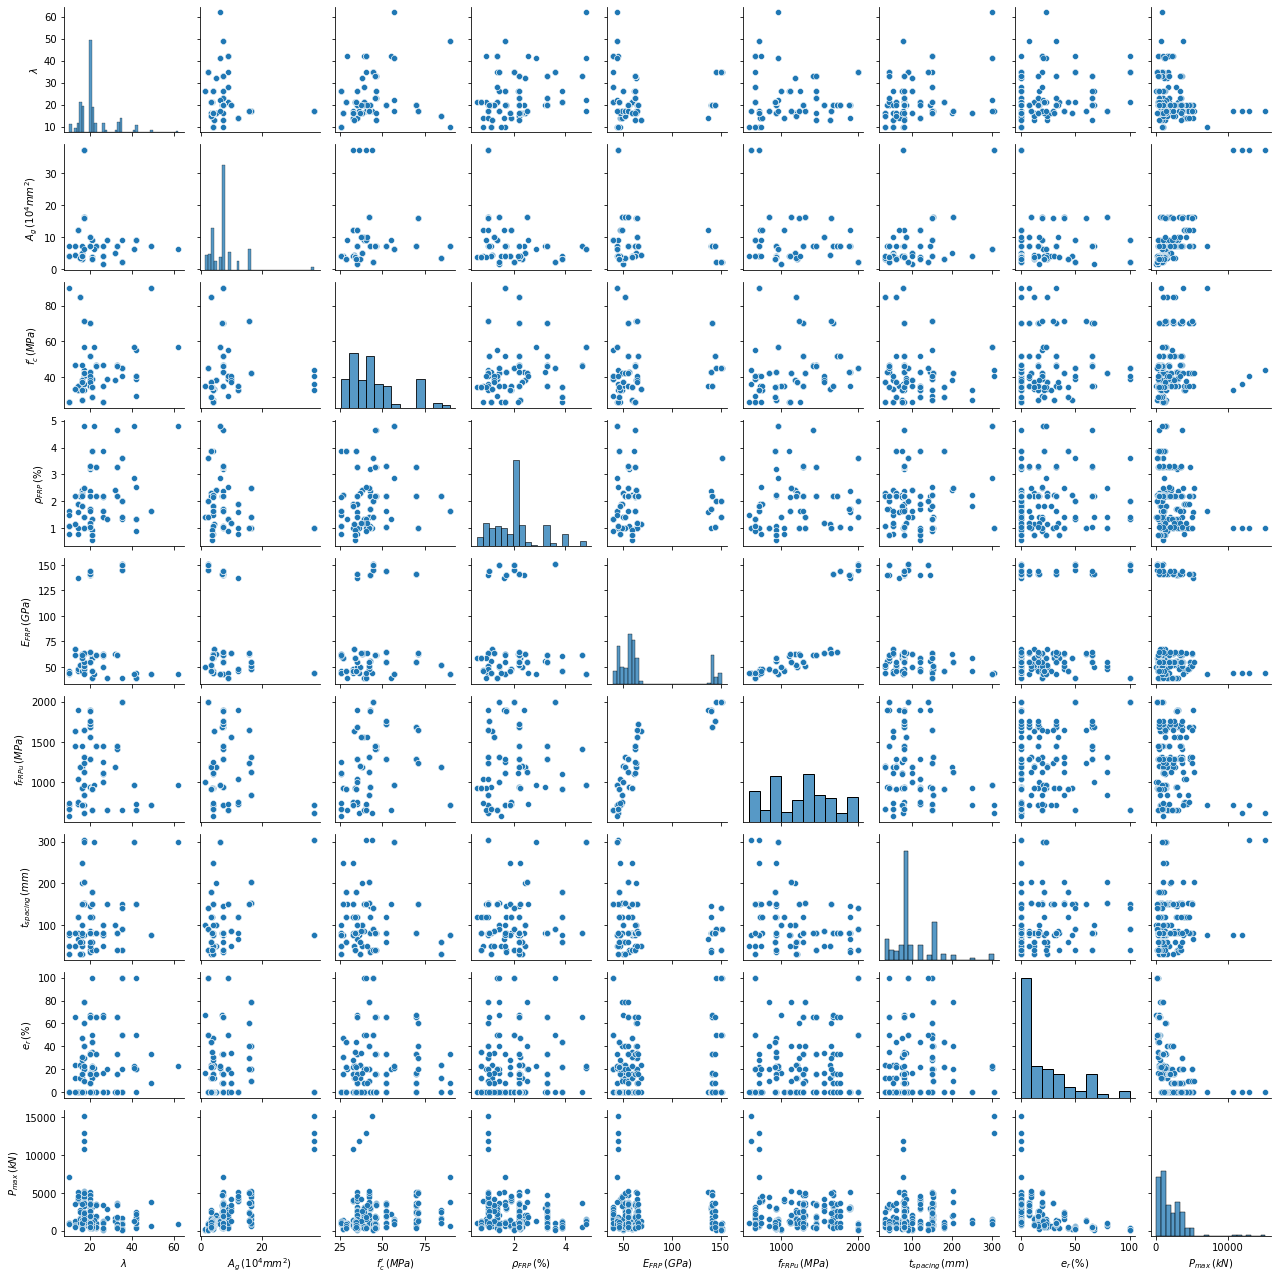

In [17]:
g=sns.pairplot(AgData, diag_kind = 'hist', height=2)


for i in range(9):
    for j in range(9):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

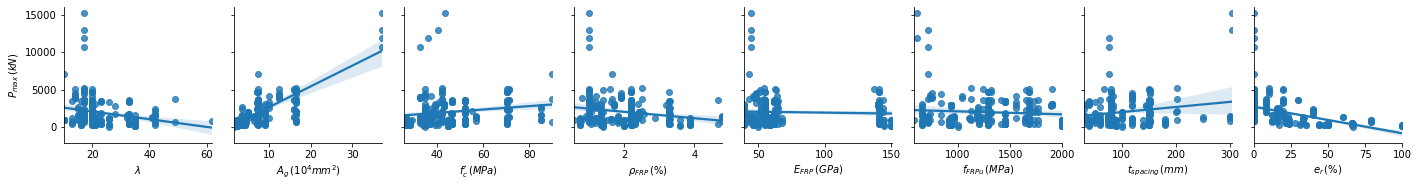

In [18]:
g = sns.pairplot(AgData, height=2.5, 
             x_vars=["LamdaC","Ag","fcp","RhoEf","EfrpL", "ffuL","SpacPitch","EoverD"],y_vars=["Pexp"],kind="reg",diag_kind=None )

for i in range(1):
    for j in range(8):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

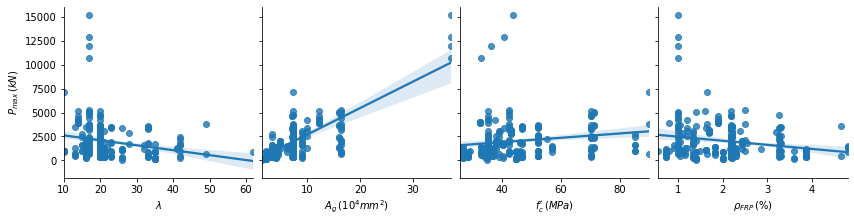

In [19]:
g = sns.pairplot(AgData, height=3, 
             x_vars=["LamdaC","Ag","fcp","RhoEf"],y_vars=["Pexp"],kind="reg",diag_kind=None )

for i in range(1):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

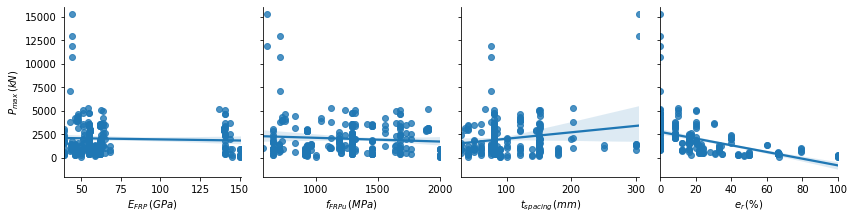

In [20]:
g = sns.pairplot(AgData, height=3, 
             x_vars=["EfrpL", "ffuL","SpacPitch","EoverD"],y_vars=["Pexp"],kind="reg",diag_kind=None )

for i in range(1):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

# 4.0 Results in XGBoost with all Data

In [21]:
y = Data['Pexp']
X = Data.drop('Pexp', axis = 1)

X.head()

,LamdaC,Circular,Ag,TypeCon,fcp,TypeL,RhoEf,EfrpL,ffuL,TypeH,Config,SpacPitch,EoverD
0,17.0,No,372100.0,NWC,43.7,GFRP,1.0,44.2,608.0,GFRP,Ties,305.0,0.0
1,17.0,No,372100.0,NWC,40.6,GFRP,1.0,44.4,712.0,GFRP,Ties,305.0,0.0
2,17.0,No,372100.0,NWC,36.1,GFRP,1.0,44.2,608.0,GFRP,Ties,76.0,0.0
3,17.0,No,372100.0,NWC,32.8,GFRP,1.0,44.4,712.0,GFRP,Ties,76.0,0.0
4,14.0,No,122500.0,NWC,32.6,GFRP,1.9,47.6,728.0,GFRP,Ties,120.0,0.0


In [22]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,SpacPitch,EoverD,Circular_Yes,TypeCon_LWC,TypeCon_NWC,TypeL_CFRP,TypeL_GFRP,TypeH_CFRP,TypeH_GFRP,TypeH_Steel,Config_Spiral,Config_Ties
0,17.0,372100.0,43.7,1.0,44.2,608.0,305.0,0.0,0,0,1,0,1,0,1,0,0,1
1,17.0,372100.0,40.6,1.0,44.4,712.0,305.0,0.0,0,0,1,0,1,0,1,0,0,1
2,17.0,372100.0,36.1,1.0,44.2,608.0,76.0,0.0,0,0,1,0,1,0,1,0,0,1
3,17.0,372100.0,32.8,1.0,44.4,712.0,76.0,0.0,0,0,1,0,1,0,1,0,0,1
4,14.0,122500.0,32.6,1.9,47.6,728.0,120.0,0.0,0,0,1,0,1,0,1,0,0,1


In [23]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [24]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 177.760619
MAE: 104.010103
MAPE: 0.069501
R2: 0.983803


# 5.0 Results in XGBoost without confinement

In [25]:
y = DataNoConfin['Pexp']
X = DataNoConfin.drop('Pexp', axis = 1)

X.head()

,LamdaC,Circular,Ag,TypeCon,fcp,TypeL,RhoEf,EfrpL,ffuL,EoverD
0,17.0,No,372100.0,NWC,43.7,GFRP,1.0,44.2,608.0,0.0
1,17.0,No,372100.0,NWC,40.6,GFRP,1.0,44.4,712.0,0.0
2,17.0,No,372100.0,NWC,36.1,GFRP,1.0,44.2,608.0,0.0
3,17.0,No,372100.0,NWC,32.8,GFRP,1.0,44.4,712.0,0.0
4,14.0,No,122500.0,NWC,32.6,GFRP,1.9,47.6,728.0,0.0


In [26]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                               ], drop_first=True )
X_encoded.head()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,EoverD,Circular_Yes,TypeCon_LWC,TypeCon_NWC,TypeL_CFRP,TypeL_GFRP
0,17.0,372100.0,43.7,1.0,44.2,608.0,0.0,0,0,1,0,1
1,17.0,372100.0,40.6,1.0,44.4,712.0,0.0,0,0,1,0,1
2,17.0,372100.0,36.1,1.0,44.2,608.0,0.0,0,0,1,0,1
3,17.0,372100.0,32.8,1.0,44.4,712.0,0.0,0,0,1,0,1
4,14.0,122500.0,32.6,1.9,47.6,728.0,0.0,0,0,1,0,1


In [27]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [28]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 164.724315
MAE: 105.831029
MAPE: 0.069900
R2: 0.986092


# 6.0 Results in XGBoost with only Concentric Columns

In [29]:
y = DataConcentric['Pexp']
X = DataConcentric.drop('Pexp', axis = 1)

X.head()

,LamdaC,Circular,Ag,TypeCon,fcp,TypeL,RhoEf,EfrpL,ffuL,TypeH,Config,SpacPitch,EoverD
0,17.0,No,372100.0,NWC,43.7,GFRP,1.0,44.2,608.0,GFRP,Ties,305.0,0.0
1,17.0,No,372100.0,NWC,40.6,GFRP,1.0,44.4,712.0,GFRP,Ties,305.0,0.0
2,17.0,No,372100.0,NWC,36.1,GFRP,1.0,44.2,608.0,GFRP,Ties,76.0,0.0
3,17.0,No,372100.0,NWC,32.8,GFRP,1.0,44.4,712.0,GFRP,Ties,76.0,0.0
4,14.0,No,122500.0,NWC,32.6,GFRP,1.9,47.6,728.0,GFRP,Ties,120.0,0.0


In [30]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,SpacPitch,EoverD,Circular_Yes,TypeCon_LWC,TypeCon_NWC,TypeL_CFRP,TypeL_GFRP,TypeH_CFRP,TypeH_GFRP,TypeH_Steel,Config_Spiral,Config_Ties
0,17.0,372100.0,43.7,1.0,44.2,608.0,305.0,0.0,0,0,1,0,1,0,1,0,0,1
1,17.0,372100.0,40.6,1.0,44.4,712.0,305.0,0.0,0,0,1,0,1,0,1,0,0,1
2,17.0,372100.0,36.1,1.0,44.2,608.0,76.0,0.0,0,0,1,0,1,0,1,0,0,1
3,17.0,372100.0,32.8,1.0,44.4,712.0,76.0,0.0,0,0,1,0,1,0,1,0,0,1
4,14.0,122500.0,32.6,1.9,47.6,728.0,120.0,0.0,0,0,1,0,1,0,1,0,0,1


In [31]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [32]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 723.596101
MAE: 288.056805
MAPE: 0.059261
R2: 0.937440


# 7.0 Results in XGBoost with only Eccentric Columns

In [33]:
y = DataExcentric['Pexp']
X = DataExcentric.drop('Pexp', axis = 1)

X.head()

,LamdaC,Circular,Ag,TypeCon,fcp,TypeL,RhoEf,EfrpL,ffuL,TypeH,Config,SpacPitch,EoverD
45,26.0,No,14400.0,GC,34.90,BFRP,1.40,50.0,1000.0,Steel,Ties,100.0,67.0
46,26.0,No,14400.0,GC,34.90,BFRP,1.40,50.0,1000.0,Steel,Ties,100.0,17.0
48,49.0,Yes,73062.0,NWC,90.00,GFRP,1.65,43.0,715.0,GFRP,Spiral,76.0,8.0
49,49.0,Yes,73062.0,NWC,90.00,GFRP,1.65,43.0,715.0,GFRP,Spiral,76.0,33.0
51,13.0,No,44100.0,NWC,33.15,GFRP,1.15,67.9,1641.0,GFRP,Ties,50.0,12.0


In [34]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,SpacPitch,EoverD,Circular_Yes,TypeCon_LWC,TypeCon_NWC,TypeL_CFRP,TypeL_GFRP,TypeH_CFRP,TypeH_GFRP,TypeH_Steel,Config_Spiral,Config_Ties
45,26.0,14400.0,34.90,1.40,50.0,1000.0,100.0,67.0,0,0,0,0,0,0,0,1,0,1
46,26.0,14400.0,34.90,1.40,50.0,1000.0,100.0,17.0,0,0,0,0,0,0,0,1,0,1
48,49.0,73062.0,90.00,1.65,43.0,715.0,76.0,8.0,1,0,1,0,1,0,1,0,1,0
49,49.0,73062.0,90.00,1.65,43.0,715.0,76.0,33.0,1,0,1,0,1,0,1,0,1,0
51,13.0,44100.0,33.15,1.15,67.9,1641.0,50.0,12.0,0,0,1,0,1,0,1,0,0,1


In [35]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [36]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 192.121050
MAE: 130.365674
MAPE: 0.100565
R2: 0.961724


# 8.0 Results in XGBoost with hyperparameter tuning with Random Search and Grid Search for all Data

In [37]:
y = Data['Pexp']
X = Data.drop('Pexp', axis = 1)

X.head()

,LamdaC,Circular,Ag,TypeCon,fcp,TypeL,RhoEf,EfrpL,ffuL,TypeH,Config,SpacPitch,EoverD
0,17.0,No,372100.0,NWC,43.7,GFRP,1.0,44.2,608.0,GFRP,Ties,305.0,0.0
1,17.0,No,372100.0,NWC,40.6,GFRP,1.0,44.4,712.0,GFRP,Ties,305.0,0.0
2,17.0,No,372100.0,NWC,36.1,GFRP,1.0,44.2,608.0,GFRP,Ties,76.0,0.0
3,17.0,No,372100.0,NWC,32.8,GFRP,1.0,44.4,712.0,GFRP,Ties,76.0,0.0
4,14.0,No,122500.0,NWC,32.6,GFRP,1.9,47.6,728.0,GFRP,Ties,120.0,0.0


In [38]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

,LamdaC,Ag,fcp,RhoEf,EfrpL,ffuL,SpacPitch,EoverD,Circular_Yes,TypeCon_LWC,TypeCon_NWC,TypeL_CFRP,TypeL_GFRP,TypeH_CFRP,TypeH_GFRP,TypeH_Steel,Config_Spiral,Config_Ties
0,17.0,372100.0,43.7,1.0,44.2,608.0,305.0,0.0,0,0,1,0,1,0,1,0,0,1
1,17.0,372100.0,40.6,1.0,44.4,712.0,305.0,0.0,0,0,1,0,1,0,1,0,0,1
2,17.0,372100.0,36.1,1.0,44.2,608.0,76.0,0.0,0,0,1,0,1,0,1,0,0,1
3,17.0,372100.0,32.8,1.0,44.4,712.0,76.0,0.0,0,0,1,0,1,0,1,0,0,1
4,14.0,122500.0,32.6,1.9,47.6,728.0,120.0,0.0,0,0,1,0,1,0,1,0,0,1


In [39]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [40]:
model_xgb = xgb.XGBRegressor(n_estimators =100,
                            max_depth=10,
                             #colsample_bytree= 0.95,
                            alpha=1,
                            subsample=0.90,
                            learning_rate=0.1,
                            random_state=123)

In [41]:
model_xgb.fit(X_train, y_train)
preds = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))


RMSE: 162.008743
MAE: 105.426189
MAPE: 0.064889
R2: 0.986546


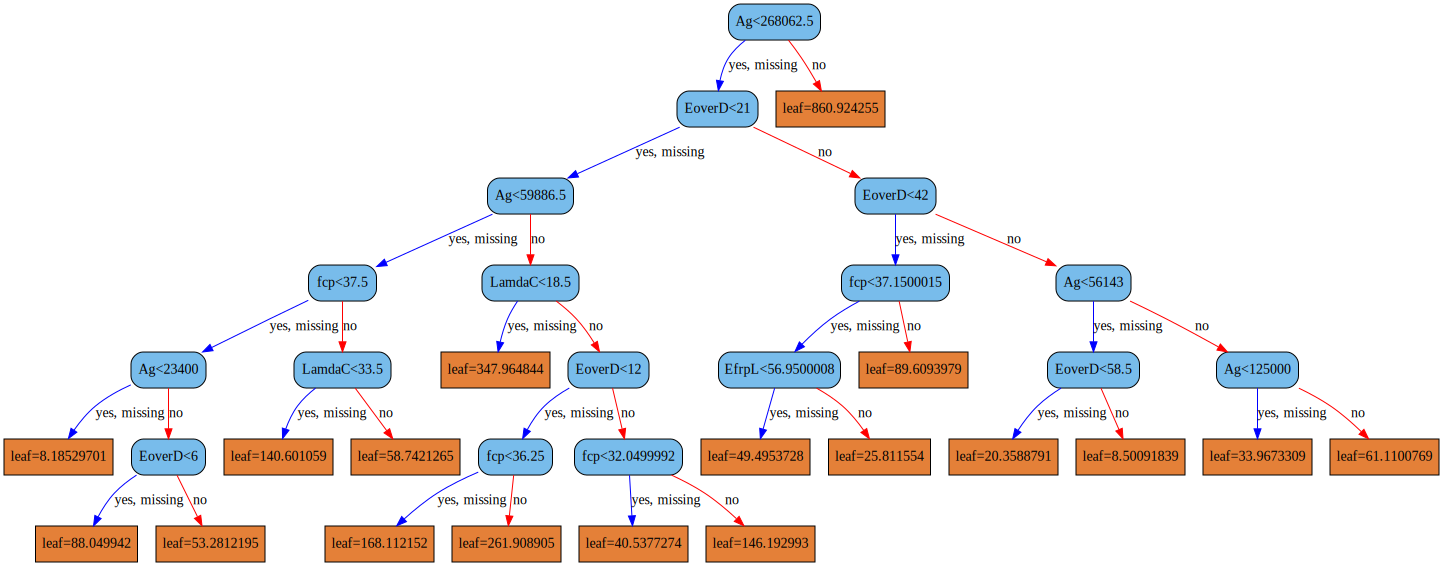

In [42]:
tr= xgb.to_graphviz(model_xgb, num_trees=2, condition_node_params={'shape': 'box',
 'style': 'filled,rounded', 'fillcolor': '#78bceb'},leaf_node_params={'shape': 'box',
 'style': 'filled',
 'fillcolor': '#e48038'})
tr

# 9.0 Interpretation of XGBoost prediction model using SHAP values

In [43]:
featureName=[r'$\lambda$',r'$A_g$', r'$f^\prime_c$', r'$\rho_{FRP}$', r'$E_{FRP}$',r'$f_{FRPu}$',r'$t_{spacing}$',r'$e_{r}$',
           r'$section_{type = circular}$',  r'$concrete_{type = LWC}$',r'$concrete_{type = NWC}$', r'$l_{type = CFRP}$',
          r'$l_{type = GFRP}$',r'$t_{type = CFRP}$',r'$t_{type = GFRP}$',r'$t_{type = steel}$',r'$t_{conf. = spiral}$',
          r'$t_{conf. = ties}$']

In [44]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (15, 4)
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman" # ou serif


#import xgboost
#import shap
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
#model = xgb.train({"learning_rate": 0.2}, xgb.DMatrix(X_encoded, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_encoded)



## 9.1 SHAP summary plot

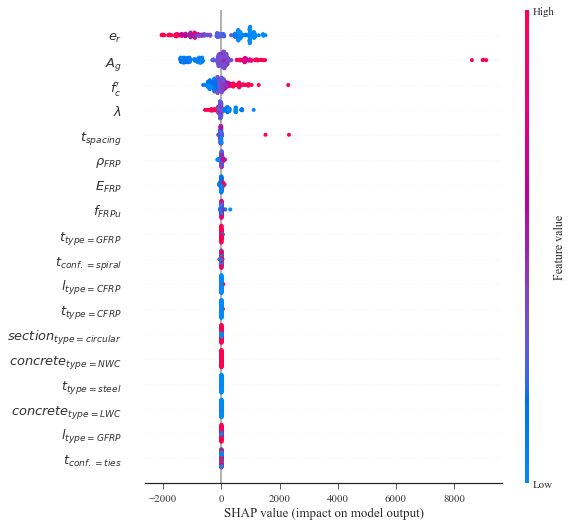

In [45]:
# summarize the effects of all the features
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 20
plt.rcParams["font.family"] = "Times New Roman" 
shap.summary_plot(shap_values, X_encoded, feature_names= featureName,show=False)

## 9.2 Relative importance for each feature

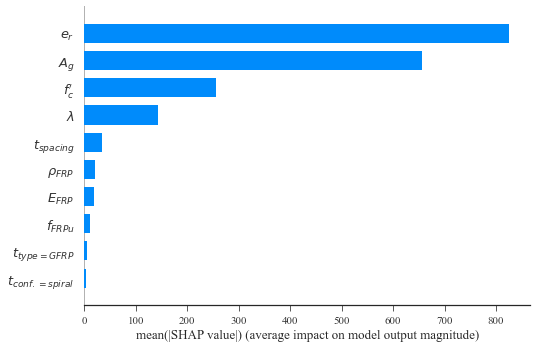

In [46]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman" 
shap.summary_plot(shap_values, X_encoded, plot_type="bar",feature_names=featureName, max_display=10,show=False)

## 9.3 Explanation of typical individual prediction for specimens 

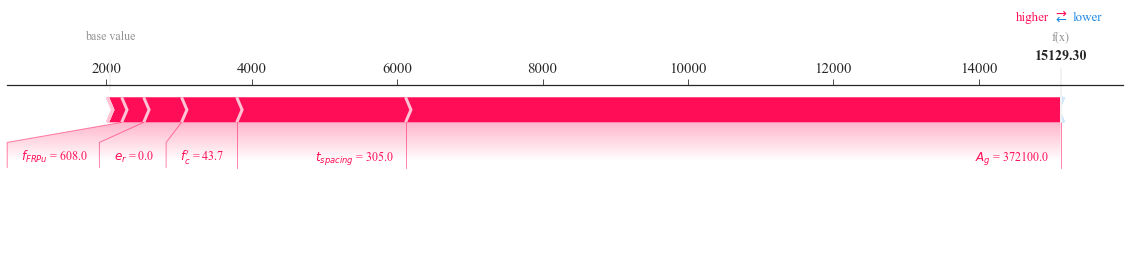

In [47]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
force=shap.force_plot(explainer.expected_value, shap_values[0,:], X_encoded.iloc[0,:], feature_names=featureName, matplotlib = True,show=False) 


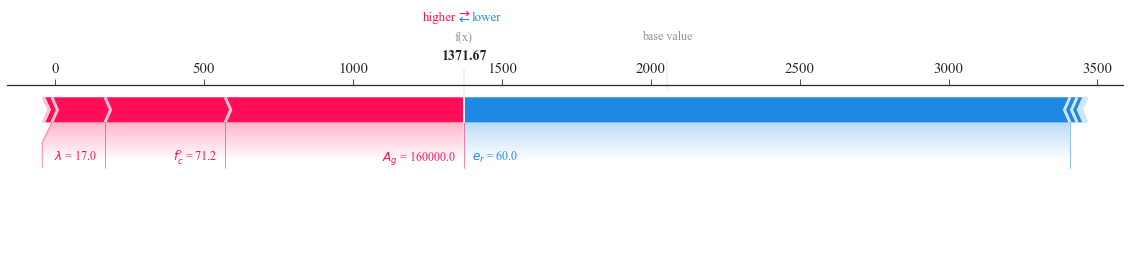

In [48]:
force=shap.force_plot(explainer.expected_value, shap_values[156,:], X_encoded.iloc[156,:], feature_names=featureName, matplotlib = True,show=False) 

## 9.4 SHAP Dependence Plots


In [49]:
featureName=[r'$\lambda$',r'$A_g\,(mm^{2})$', r'$f^\prime_c\,(MPa)$', r'$\rho_{FRP}\,(\%)$', r'$E_{FRP}\,(GPa)$',r'$f_{FRPu}\,(MPa)$',r'$t_{spacing}\,(mm)$',r'$e_{r}\,(\%)$',
           r'$section_{type = circular}$',  r'$concrete_{type = LWC}$',r'$concrete_{type = NWC}$', r'$l_{type = CFRP}$',
          r'$l_{type = GFRP}$',r'$t_{type = CFRP}$',r'$t_{type = GFRP}$',r'$t_{type = steel}$',r'$t_{conf. = spiral}$',
          r'$t_{conf. = ties}$']

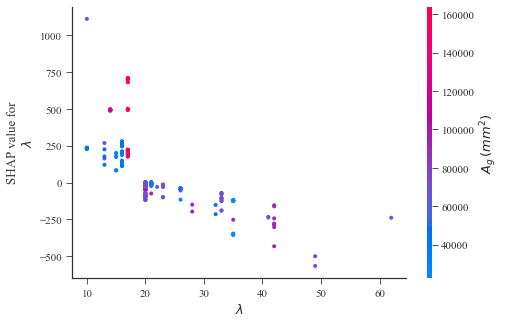

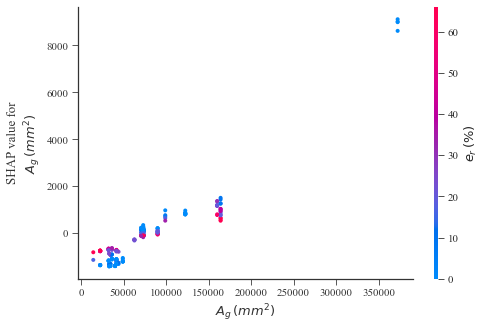

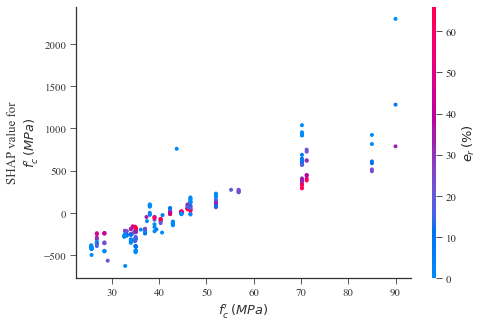

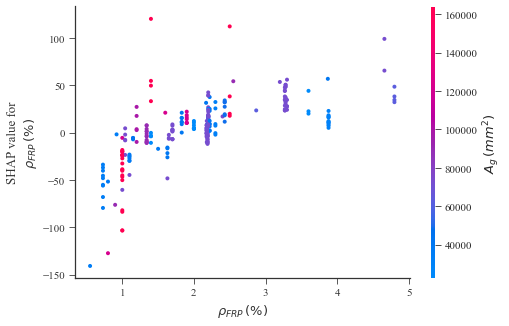

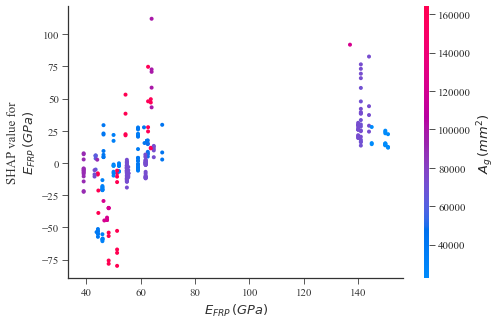

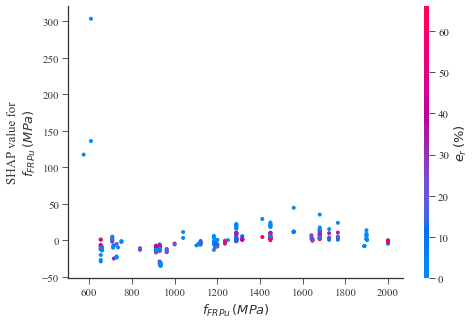

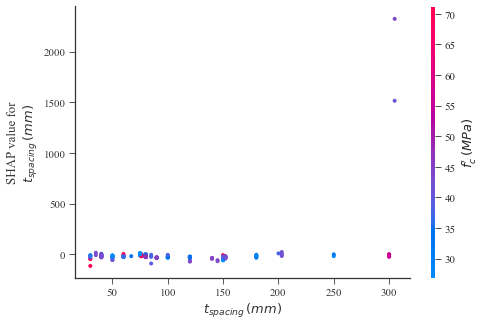

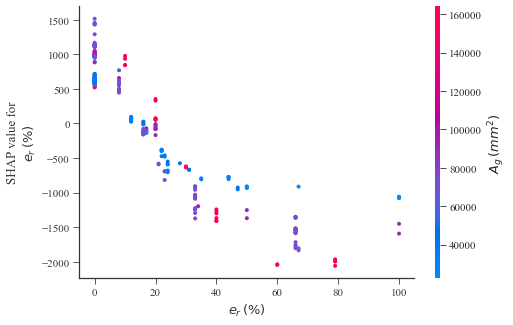

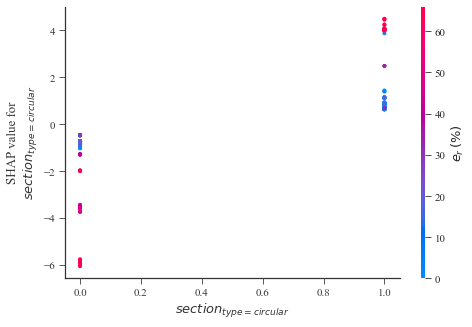

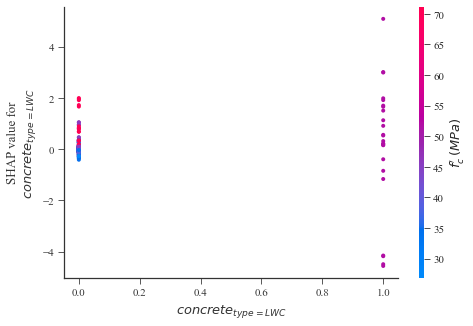

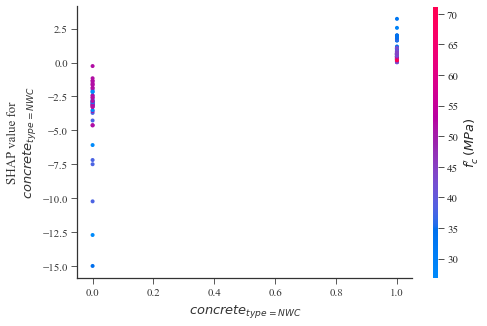

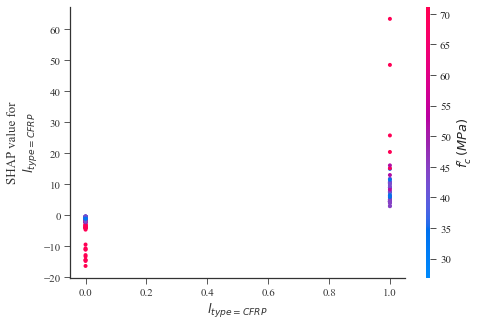

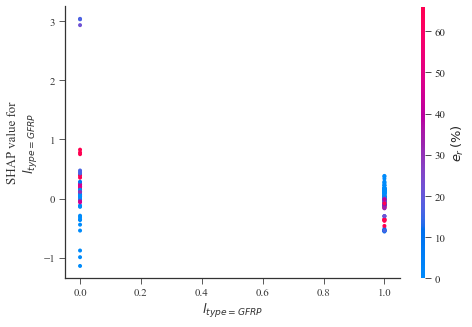

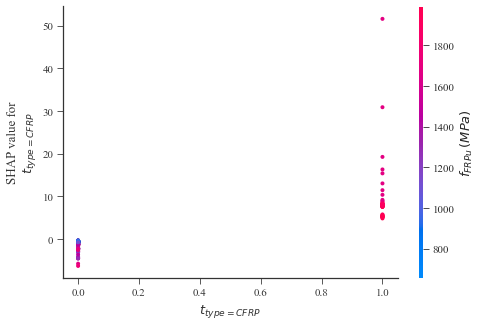

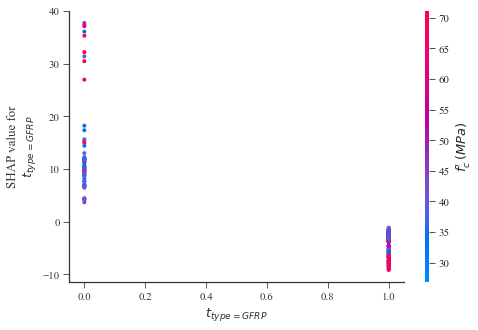

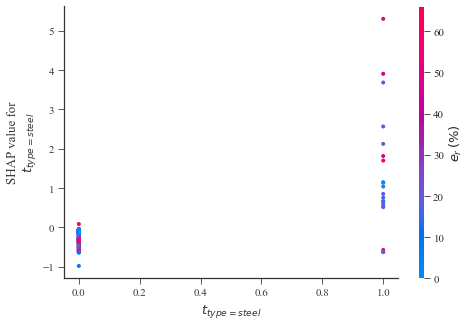

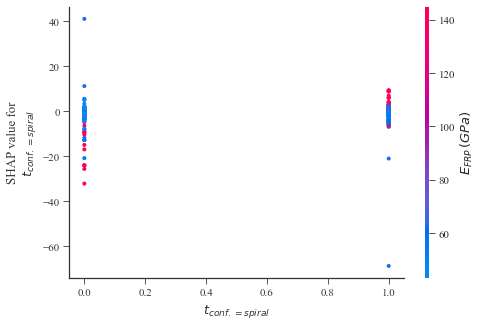

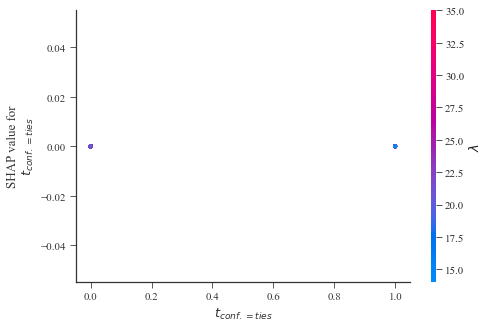

In [50]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman" # ou serif
#fig, ax = plt.subplots(figsize=(8, 5))
length = len(featureName)
for i in range(length):
    name =X_train.columns[i]
    shap.dependence_plot(i, shap_values, X_encoded,feature_names=featureName, show = False)
    plt.show()
